In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal

In [2]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [3]:
tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical.nc')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth.nc')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth.nc')

tropical_reforecast_clim   = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')
coastnorth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastnorth_clim.nc')
coastsouth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')

In [4]:
tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').convert_calendar('noleap', dim='time')
tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').convert_calendar('noleap', dim='inittime')

coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').convert_calendar('noleap', dim='time')
coastnorth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastnorth.nc').convert_calendar('noleap', dim='inittime')

coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').convert_calendar('noleap', dim='time')
coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').convert_calendar('noleap', dim='inittime')

---

##### check anomaly forecast for some study cases

In [5]:
north_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastnorth_glorys.groupby('time.dayofyear')-coastnorth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')

south_glorys = xr.concat([tropical_glorys.groupby('time.dayofyear')-tropical_glorys_clim,
                          coastsouth_glorys.groupby('time.dayofyear')-coastsouth_glorys_clim
                         ],'index').convert_calendar('gregorian').drop('dayofyear')


In [6]:
north_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastnorth_reforecast.groupby('inittime.dayofyear')-coastnorth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear')

south_reforecast = xr.concat([tropical_reforecast.groupby('inittime.dayofyear')-tropical_reforecast_clim,
                          coastsouth_reforecast.groupby('inittime.dayofyear')-coastsouth_reforecast_clim
                         ],'index').convert_calendar('gregorian', dim='inittime').drop('dayofyear')

In [178]:
def filter_hovmoller(data, var):
    x = filter_xarray(data[var],'time',5, 1/180, btype='highpass').swap_dims({'index':'distance'})
    # x = filter_xarray(x, 'distance', 5, 1/100)
    return x

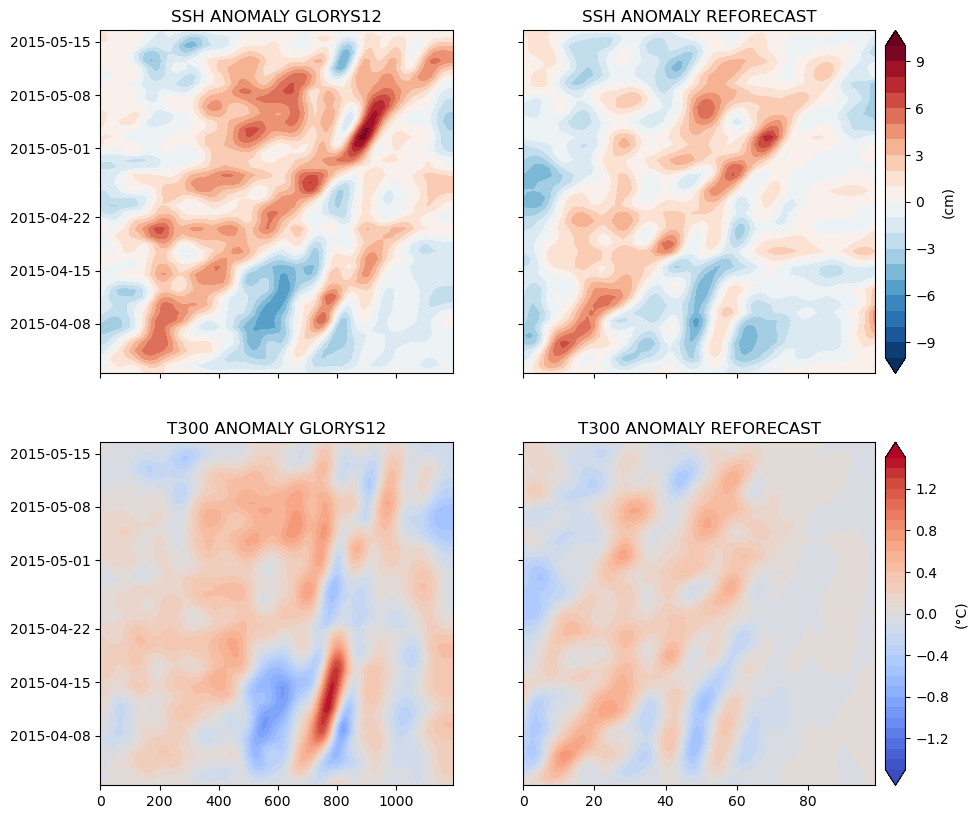

In [29]:
fig, ax = plt.subplots(2,2, sharex='col', sharey=True, facecolor='w', dpi=100, figsize=(10,10))

trange = slice('2015-04-01','2015-05-16')
x = filter_xarray(south_glorys.sel(time=trange),'time',5,1/180,btype='highpass').swap_dims({'index':'distance'})
x = filter_xarray(x,'distance',5,1/100).swap_dims({'distance':'index'})
m1=ax[0,0].contourf(south_glorys.sel(time=trange).index,south_glorys.sel(time=trange).time, x.zos*100, levels=np.arange(-10,10+1,1), cmap='RdBu_r', extend='both')
m2=ax[1,0].contourf(south_glorys.sel(time=trange).index,south_glorys.sel(time=trange).time, x['T300'], levels=np.arange(-1.5,1.5+0.1,0.1), cmap='coolwarm', extend='both')

y = filter_xarray(south_reforecast.sel(inittime=trange.start),'leadtime',5,1/180,btype='highpass').swap_dims({'index':'distance'})
y = filter_xarray(y.drop_duplicates('distance'),'distance',5,1/10).swap_dims({'distance':'index'})

ax[0,1].contourf(south_reforecast.sel(inittime=trange.start).index,south_glorys.sel(time=trange).time,
                 y.zos*100,levels=np.arange(-10,10+1,1),
                 cmap='RdBu_r', extend='both')

ax[1,1].contourf(south_reforecast.sel(inittime=trange.start).index,south_glorys.sel(time=trange).time,
                 y['T300'],levels=np.arange(-1.5,1.5+0.1,0.1),
                 cmap='coolwarm', extend='both')

ax[0,0].set_title('SSH ANOMALY GLORYS12')
ax[0,1].set_title('SSH ANOMALY REFORECAST')

ax[1,0].set_title('T300 ANOMALY GLORYS12')
ax[1,1].set_title('T300 ANOMALY REFORECAST')


box1 = ax[0,-1].get_position()
cax1 = fig.add_axes([box1.xmax+0.01,box1.ymin,0.02,box1.ymax-box1.ymin])

box2 = ax[1,-1].get_position()
cax2 = fig.add_axes([box2.xmax+0.01,box2.ymin,0.02,box2.ymax-box2.ymin])

fig.colorbar(m1,cax=cax1, label='(cm)')
fig.colorbar(m2,cax=cax2, label='(°C)')

# ax[0,0].set_xticklabels(np.round(south_glorys.distance.sel(index=ax[0,0].get_xticks()[:-1]).values,0))
# ax[0,1].set_xticklabels(np.round(south_reforecast.distance.sel(index=ax[0,1].get_xticks()[:-1]).values,0))